## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [13]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [14]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf


from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Because of we are having memory issues, we are going to limit usage

tf.config.experimental.set_virtual_device_configuration(
    tf.config.experimental.list_physical_devices('GPU')[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [15]:
tf.test.is_built_with_cuda()

True

In [16]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [19]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


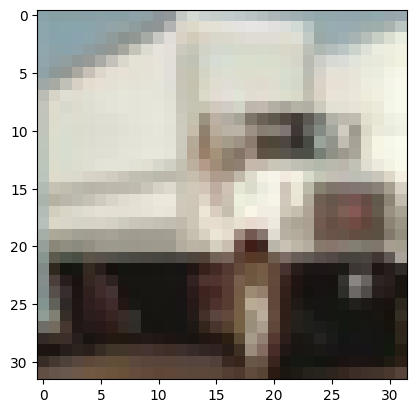

In [20]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])
plt.imshow(x_train[image_no]);

In [21]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [23]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [24]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 16, 16, 32)        2432      
                                                                 
 conv2d_19 (Conv2D)          (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               147968    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

We still have 181K parameters, even though this is a "small" model.


In [25]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 17s 9ms/step - loss: 1.6687 - accuracy: 0.3971 - val_loss: 1.4649 - val_accuracy: 0.4815
Epoch 2/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.3559 - accuracy: 0.5145 - val_loss: 1.2694 - val_accuracy: 0.5519
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.2352 - accuracy: 0.5616 - val_loss: 1.1854 - val_accuracy: 0.5865
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1578 - accuracy: 0.5908 - val_loss: 1.1893 - val_accuracy: 0.5784
Epoch 5/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.1037 - accuracy: 0.6125 - val_loss: 1.1530 - val_accuracy: 0.5982
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0650 - accuracy: 0.6270 - val_loss: 1.1150 - val_accuracy: 0.6129
Epoch 7/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.0278 - accuracy: 0.6431 - val_loss: 1.0527 - val_ac

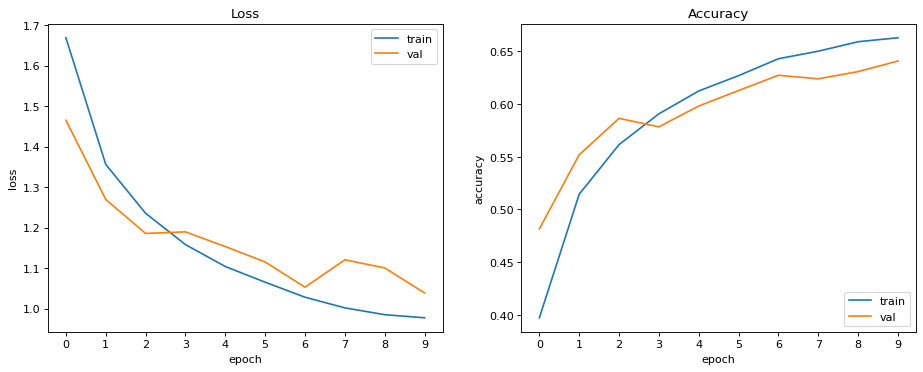

In [26]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

### Model Evaluation

In [27]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.875759, Accuracy: 0.696720
 Test Loss: 1.038472, Accuracy: 0.640900

[[726  16  73  22  28  13   2  16 103  39]
 [ 29 757  10  17   5   6   6   3  54 133]
 [ 44   7 398  46  42  33  18  23   9  12]
 [ 23   8  79 409  55 172  30  35  22  18]
 [ 24   4 125  82 602  72  14 103  13   8]
 [  7   6  80 163  33 539  16  90   8  12]
 [ 32  34 179 188 166 105 892  38  22  25]
 [ 10   4  26  38  53  43   6 652   6  18]
 [ 66  27  14  17  10  11   6   6 721  22]
 [ 39 137  16  18   6   6  10  34  42 713]]


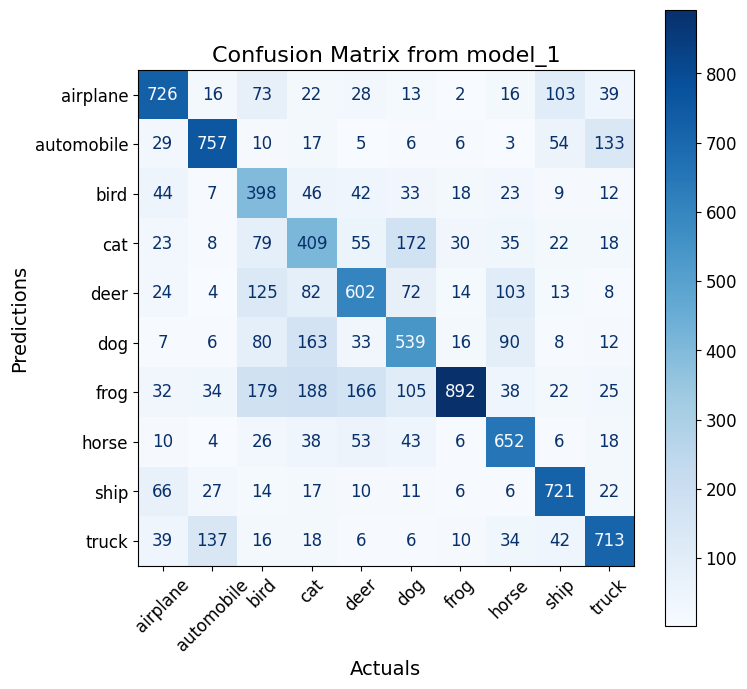

In [28]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [29]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

tf.keras.backend.clear_session()

              precision    recall  f1-score   support

    airplane       0.70      0.73      0.71      1000
  automobile       0.74      0.76      0.75      1000
        bird       0.63      0.40      0.49      1000
         cat       0.48      0.41      0.44      1000
        deer       0.57      0.60      0.59      1000
         dog       0.56      0.54      0.55      1000
        frog       0.53      0.89      0.67      1000
       horse       0.76      0.65      0.70      1000
        ship       0.80      0.72      0.76      1000
       truck       0.70      0.71      0.71      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000



$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$

where 
$TP$: True Positives, $TN$: True Negatives, $FP$: False Positives, and $FN$: False Negatives


### <span style="color:blue">แบบฝึกปฏิบัติ</span>
จากโครงสร้างของโมเดลเดิม:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:
   - Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

   - ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

2. เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

3. จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report

4. หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

### <span style="color:pink">จากแบบฝึกปฏิบัติ</span>

In [30]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 32)        25632     
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

Notice: การ complie model ที่ได้ 3 นาทีเกิดจากการใช้ GPU ในการ complie
<p>
แต่ถ้าใช้ CPU ในการ complie จะใช้เวลา 30 นาทีแทน 
(ผู้ train model ใช้งานทำอย่างอื่นด้วย แต่ CPU Usage ถูกใช้ 100% อยู่แล้ว ในกรณีนี้)

In [31]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 1.5979 - accuracy: 0.4196

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/conv2d_20/Relu' defined at (most recent call last):
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\kernel\__main__.py", line 15, in <module>
      app.launch_new_instance(kernel_class=IPyflowKernel)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\kernel\kernel.py", line 196, in do_execute
      ret = await super_.do_execute(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\shell\interactiveshell.py", line 327, in run_cell
      return super().run_cell(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\shell\interactiveshell.py", line 363, in run_cell_async
      ret = await self._ipyflow_run_cell(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\shell\interactiveshell.py", line 402, in _ipyflow_run_cell
      ret = await super().run_cell_async(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_25044\3025895220.py", line 11, in <module>
      history_1 = model_1.fit(x_train, y_train,
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1606, in fit
      val_logs = self.evaluate(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/conv2d_20/Relu'
OOM when allocating tensor with shape[32,32,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/conv2d_20/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_95510]

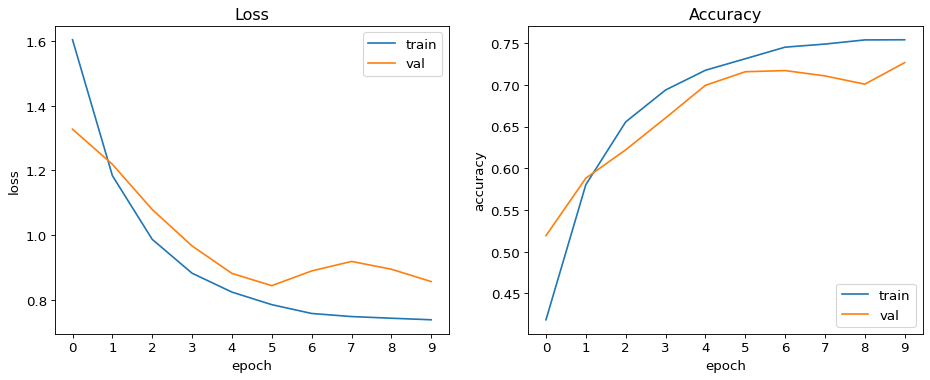

In [ ]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [ ]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.615851, Accuracy: 0.791380
 Test Loss: 0.856257, Accuracy: 0.726600

[[817  12  77  43  27  27  11  32  89  33]
 [ 13 879   7  11   3   6   3   1  25  74]
 [ 35   1 607  85  48  80  35  45  12  10]
 [ 15   3  38 492  33 195  24  31  10   6]
 [ 21   3 135 117 753  76  49 120   6   5]
 [  2   0  27  81   7 483   1  19   2   3]
 [  6   8  75 109  85  68 864  17   4  13]
 [  8   2  19  33  32  46   0 715   1  10]
 [ 45  23   7  12   6   5  10   1 829  19]
 [ 38  69   8  17   6  14   3  19  22 827]]


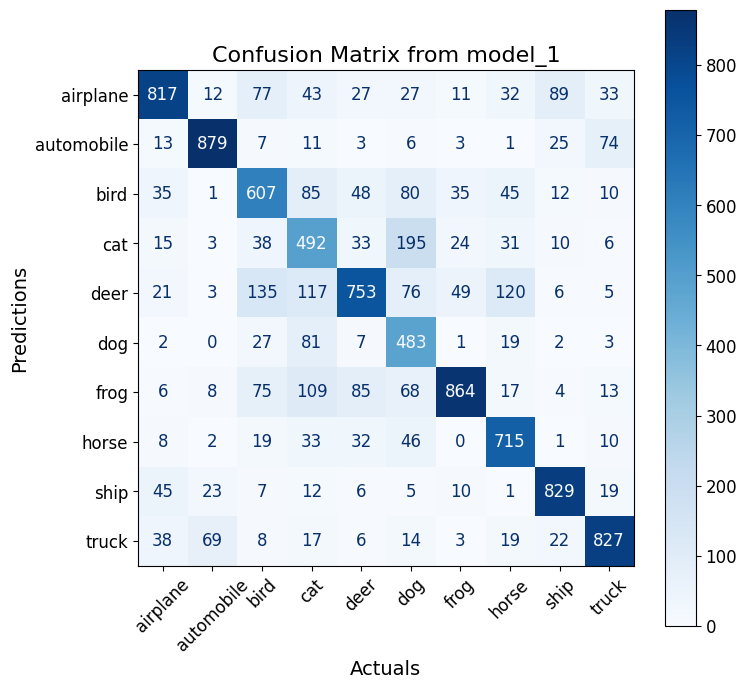

In [ ]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [ ]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.70      0.82      0.75      1000
  automobile       0.86      0.88      0.87      1000
        bird       0.63      0.61      0.62      1000
         cat       0.58      0.49      0.53      1000
        deer       0.59      0.75      0.66      1000
         dog       0.77      0.48      0.59      1000
        frog       0.69      0.86      0.77      1000
       horse       0.83      0.71      0.77      1000
        ship       0.87      0.83      0.85      1000
       truck       0.81      0.83      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.72     10000



[   9   12   17 ... 9993 9995 9998]
Image number: 9
Actual label: automobile
Predicted label: truck


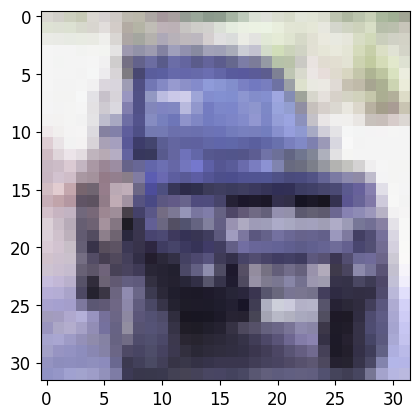

In [ ]:
# Show an incorrect prediction image from the test set and tell us what it was supposed to be

incorrect = np.nonzero(y_pred_1d != y_test_1d)[0]
print(incorrect)
image_no = incorrect[0]
print('Image number:', image_no)
print('Actual label:', class_names[y_test_1d[image_no]])
print('Predicted label:', class_names[y_pred_1d[image_no]])
plt.imshow(x_test[image_no])

tf.keras.backend.clear_session()

LeNet-5 with RGB color

In [ ]:
# Using LeNet-5 Architecture
set_seed(12345)

model_1 = Sequential()

model_1.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32,32,3)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())

# model_1.add(Dense(units=400, activation='relu'))

model_1.add(Dense(units=120, activation='relu'))

model_1.add(Dense(units=84, activation='relu'))

model_1.add(Dense(num_classes, activation = 'softmax'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 120)              

In [ ]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 17s 10ms/step - loss: 1.7266 - accuracy: 0.3720 - val_loss: 1.5796 - val_accuracy: 0.4216
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.4709 - accuracy: 0.4685 - val_loss: 1.5251 - val_accuracy: 0.4507
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.3632 - accuracy: 0.5110 - val_loss: 1.3492 - val_accuracy: 0.5107
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.2813 - accuracy: 0.5411 - val_loss: 1.3314 - val_accuracy: 0.5204
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.2188 - accuracy: 0.5655 - val_loss: 1.2566 - val_accuracy: 0.5485
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1665 - accuracy: 0.5857 - val_loss: 1.3038 - val_accuracy: 0.5442
Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1209 - accuracy: 0.6048 - val_loss: 1.3960 - val_a

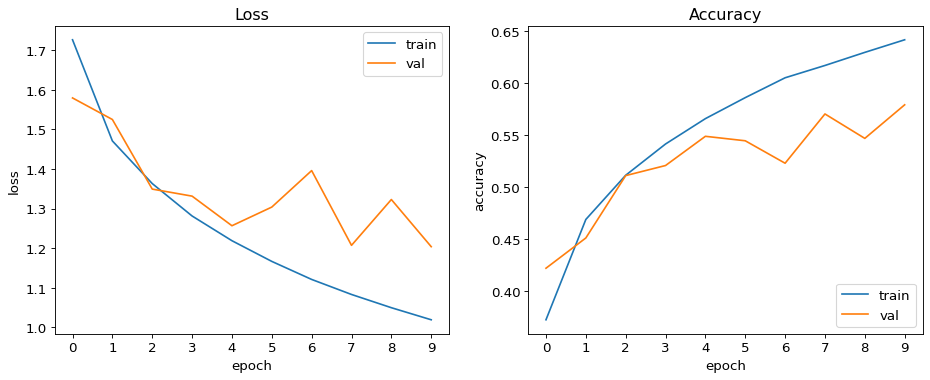

In [ ]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [ ]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 1.015198, Accuracy: 0.641440
 Test Loss: 1.203703, Accuracy: 0.578800

[[662  19  72  24  31   7   6  20 134  22]
 [ 50 690  31  32  11  15  23  25 101 116]
 [ 24   3 354  55  66  63  26  15   6  10]
 [ 14   6  61 341  43 198  39  44   8  11]
 [ 34   2 145 102 524  92  34  82  12   9]
 [  8   3  52 133  24 390  13  49   3   7]
 [ 27  14 159 184 168 108 816  37  11  22]
 [ 10   5  51  52  89  86  10 666   6  17]
 [ 74  23  22  16  20  13   5   2 584  25]
 [ 97 235  53  61  24  28  28  60 135 761]]


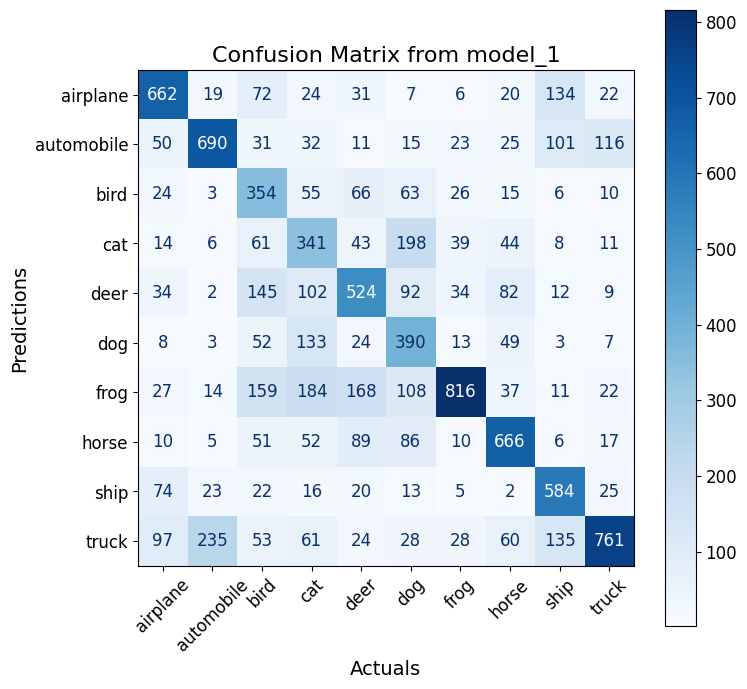

In [ ]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [ ]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.66      0.66      0.66      1000
  automobile       0.63      0.69      0.66      1000
        bird       0.57      0.35      0.44      1000
         cat       0.45      0.34      0.39      1000
        deer       0.51      0.52      0.51      1000
         dog       0.57      0.39      0.46      1000
        frog       0.53      0.82      0.64      1000
       horse       0.67      0.67      0.67      1000
        ship       0.74      0.58      0.65      1000
       truck       0.51      0.76      0.61      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.57     10000
weighted avg       0.58      0.58      0.57     10000



Image number: 1
Actual label: ship
Predicted label: automobile


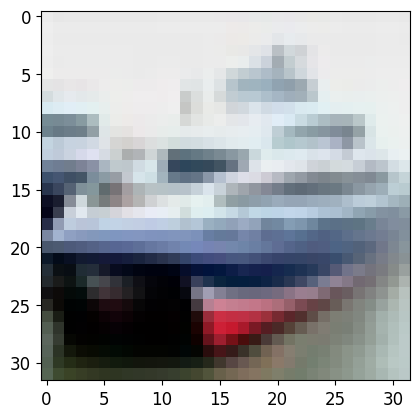

In [ ]:
# Show an incorrect prediction image from the test set and tell us what it was supposed to be

incorrect = np.nonzero(y_pred_1d != y_test_1d)[0]
image_no = incorrect[0]
print('Image number:', image_no)
print('Actual label:', class_names[y_test_1d[image_no]])
print('Predicted label:', class_names[y_pred_1d[image_no]])
plt.imshow(x_test[image_no])

tf.keras.backend.clear_session()

Modified AlexNet for 32x32 (Failed)

Using ResNet50

In [ ]:
# Making ResNet50 from scratch

set_seed(12345)

def residual_block(x, downsample, filters, kernel_size=3):
    y = layers.Conv2D(kernel_size=kernel_size,
                      strides=(1 if not downsample else 2),
                      filters=filters,
                      padding="same")(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu")(y)

    y = layers.Conv2D(kernel_size=kernel_size,
                      strides=1,
                      filters=filters,
                      padding="same")(x)
    y = layers.BatchNormalization()(y)

    if downsample:
        x = layers.Conv2D(kernel_size=1,
                          strides=2,
                          filters=filters,
                          padding="same")(x)
        x = layers.BatchNormalization()(x)

    out = layers.Add()([x, y])
    out = layers.Activation("relu")(out)
    return out

ValueError: Inputs have incompatible shapes. Received shapes (4, 4, 128) and (8, 8, 64)

In [ ]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
# model_1.compile(loss='categorical_crossentropy',
#                 optimizer=opt,
#                 metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'RMSprop/RMSprop/update_12/mul_2' defined at (most recent call last):
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\kernel\__main__.py", line 15, in <module>
      app.launch_new_instance(kernel_class=IPyflowKernel)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\kernel\kernel.py", line 196, in do_execute
      ret = await super_.do_execute(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\shell\interactiveshell.py", line 327, in run_cell
      return super().run_cell(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\shell\interactiveshell.py", line 363, in run_cell_async
      ret = await self._ipyflow_run_cell(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\ipyflow\shell\interactiveshell.py", line 402, in _ipyflow_run_cell
      ret = await super().run_cell_async(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_6712\3025895220.py", line 11, in <module>
      history_1 = model_1.fit(x_train, y_train,
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
      return self.apply_gradients(grads_and_vars, name=name)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 738, in apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 797, in _distributed_apply
      update_op = distribution.extended.update(
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 776, in apply_grad_to_update_var
      update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
    File "c:\Users\USER\anaconda3\envs\dl_env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py", line 241, in _resource_apply_dense
      var_t = var - coefficients["lr_t"] * grad / (
Node: 'RMSprop/RMSprop/update_12/mul_2'
failed to allocate memory
	 [[{{node RMSprop/RMSprop/update_12/mul_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2580]

In [ ]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [ ]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

In [ ]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [ ]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

In [ ]:
# Show an incorrect prediction image from the test set and tell us what it was supposed to be

incorrect = np.nonzero(y_pred_1d != y_test_1d)[0]
image_no = incorrect[0]
print('Image number:', image_no)
print('Actual label:', class_names[y_test_1d[image_no]])
print('Predicted label:', class_names[y_pred_1d[image_no]])
plt.imshow(x_test[image_no]);